# Quantum-RAG Demo: Diversity-Aware Retrieval

This demo compares four retrieval strategies:
- **Top-K**: Traditional cosine similarity ranking
- **MMR**: Maximal Marginal Relevance (balances relevance and diversity)
- **QUBO (Gurobi)**: Quantum-inspired QUBO optimization using classical solver
- **QUBO (ORBIT)**: Quantum-inspired QUBO optimization using p-bit simulator

---

## Setup

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from core.utils import (
    load_wikipedia_dataset,
    filter_chunks_by_prompt,
    get_prompt_embedding,
    compute_aspect_recall
)
from core.retrieval import NaiveRetrieval, MMRRetrieval, QUBORetrieval
from core.data_models import RetrievalResult

print("Imports successful!")

Imports successful!


## Load Dataset

In [12]:
# Load Wikipedia dataset
chunks, embeddings = load_wikipedia_dataset('./data/wikipedia')
print(f"Loaded {len(chunks):,} chunks with {len(embeddings):,} embeddings")

Loaded 5,600 chunks with 5,600 embeddings


## Select Test Query

In [13]:
# Get first available prompt
all_prompts = [c for c in chunks if c.get('chunk_type') == 'prompt']
TEST_PROMPT_ID = all_prompts[0]['prompt_id']
prompt_text = all_prompts[0]['text']
query_embedding = get_prompt_embedding(chunks, embeddings, TEST_PROMPT_ID)

print(f"Test Prompt: {prompt_text[:150]}...")
print(f"\nQuery embedding shape: {query_embedding.shape}")

Test Prompt: Provide a comprehensive overview of Greenhouse effect, covering key aspects such as Definition, Terminology, History of discovery and investigation, M...

Query embedding shape: (1024,)


## Prepare Test Case

We'll test at **redundancy level 4** (high redundancy) where each gold aspect has 4 duplicate copies.

In [ ]:
# Get candidates at redundancy level 4
redundancy_level = 4
k = 5
candidates, gold_aspects, _, _, _ = filter_chunks_by_prompt(chunks, TEST_PROMPT_ID, redundancy_level)

# Prepare candidate data structure
candidate_results = [{
    'id': cand['chunk_id'],
    'text': cand['text'],
    'embedding': embeddings.get(cand['chunk_id']),
    'score': np.dot(
        query_embedding / np.linalg.norm(query_embedding),
        embeddings.get(cand['chunk_id']) / np.linalg.norm(embeddings.get(cand['chunk_id']))
    ),
    'metadata': cand
} for cand in candidates if embeddings.get(cand['chunk_id']) is not None]

candidate_results.sort(key=lambda x: x['score'], reverse=True)

print(f"Redundancy Level: {redundancy_level}")
print(f"Candidate pool: {len(candidate_results)} chunks")
print(f"Gold aspects: {len(gold_aspects)}")
print(f"Retrieving k={k} chunks")

## Method 1: Top-K (Baseline)

In [15]:
# Top-K retrieval
topk_strategy = NaiveRetrieval()
topk_results = topk_strategy.retrieve(query_embedding, candidate_results, k)
topk_meta = [r.chunk.metadata for r in topk_results]
topk_recall, topk_count = compute_aspect_recall(topk_meta, gold_aspects)

print("Top-K Results:")
print(f"  Aspect Recall: {topk_recall:.1f}% ({topk_count}/{len(gold_aspects)} aspects)")
print(f"\nSelected chunks:")
for i, r in enumerate(topk_results, 1):
    chunk_type = r.chunk.metadata.get('chunk_type', 'unknown')
    aspect = r.chunk.metadata.get('aspect_index', -1)
    print(f"  [{i}] Aspect {aspect} | {chunk_type} | {r.chunk.text[:60]}...")

Top-K Results:
  Aspect Recall: 20.0% (1/5 aspects)

Selected chunks:
  [1] Aspect -1 | gold_redundant | == Definition ==
The greenhouse effect on Earth is defined a...
  [2] Aspect -1 | gold_redundant | == Definition ==
The greenhouse effect on Earth is defined a...
  [3] Aspect -1 | gold_redundant | == Definition ==
The greenhouse effect on Earth is defined a...
  [4] Aspect -1 | gold_base | == Definition ==
The greenhouse effect on Earth is defined a...
  [5] Aspect -1 | gold_redundant | == Definition ==
The greenhouse effect on Earth is defined a...


## Method 2: MMR (Maximal Marginal Relevance)

In [16]:
# MMR retrieval
lambda_param = 0.85  # Balance between relevance (1.0) and diversity (0.0)
mmr_strategy = MMRRetrieval(lambda_param=lambda_param)
mmr_results = mmr_strategy.retrieve(query_embedding, candidate_results, k)
mmr_meta = [r.chunk.metadata for r in mmr_results]
mmr_recall, mmr_count = compute_aspect_recall(mmr_meta, gold_aspects)

print(f"MMR Results (lambda={lambda_param}):")
print(f"  Aspect Recall: {mmr_recall:.1f}% ({mmr_count}/{len(gold_aspects)} aspects)")
print(f"\nSelected chunks:")
for i, r in enumerate(mmr_results, 1):
    chunk_type = r.chunk.metadata.get('chunk_type', 'unknown')
    aspect = r.chunk.metadata.get('aspect_index', -1)
    print(f"  [{i}] Aspect {aspect} | {chunk_type} | {r.chunk.text[:60]}...")

MMR Results (lambda=0.85):
  Aspect Recall: 20.0% (1/5 aspects)

Selected chunks:
  [1] Aspect -1 | gold_redundant | == Definition ==
The greenhouse effect on Earth is defined a...
  [2] Aspect -1 | gold_redundant | == Definition ==
The greenhouse effect on Earth is defined a...
  [3] Aspect -1 | gold_redundant | == Definition ==
The greenhouse effect on Earth is defined a...
  [4] Aspect -1 | gold_redundant | == Definition ==
The greenhouse effect on Earth is defined a...
  [5] Aspect -1 | gold_base | == Definition ==
The greenhouse effect on Earth is defined a...


## Method 3: QUBO with Gurobi (Classical Optimizer)

In [17]:
# QUBO with Gurobi
alpha = 0.04
penalty = 10.0
beta = 0.8

gurobi_strategy = QUBORetrieval(alpha=alpha, penalty=penalty, beta=beta, solver='gurobi')
gurobi_results = gurobi_strategy.retrieve(query_embedding, candidate_results, k)
gurobi_meta = [r.chunk.metadata for r in gurobi_results]
gurobi_recall, gurobi_count = compute_aspect_recall(gurobi_meta, gold_aspects)

print(f"QUBO-Gurobi Results (alpha={alpha}, penalty={penalty}, beta={beta}):")
print(f"  Aspect Recall: {gurobi_recall:.1f}% ({gurobi_count}/{len(gold_aspects)} aspects)")
print(f"\nSelected chunks:")
for i, r in enumerate(gurobi_results, 1):
    chunk_type = r.chunk.metadata.get('chunk_type', 'unknown')
    aspect = r.chunk.metadata.get('aspect_index', -1)
    print(f"  [{i}] Aspect {aspect} | {chunk_type} | {r.chunk.text[:60]}...")

QUBO-Gurobi Results (alpha=0.04, penalty=10.0, beta=0.8):
  Aspect Recall: 80.0% (4/5 aspects)

Selected chunks:
  [1] Aspect -1 | gold_redundant | == Definition ==
The greenhouse effect on Earth is defined a...
  [2] Aspect -1 | gold_redundant | == Definition ==
The greenhouse effect on Earth is defined a...
  [3] Aspect -1 | gold_redundant | T
          
            
              e
              f
  ...
  [4] Aspect -1 | gold_redundant | Greenhouse gases make the atmosphere near Earth's surface mo...
  [5] Aspect -1 | gold_redundant | g
              ~
            
          
        
        =...


## Method 4: QUBO with ORBIT (P-bit Simulator)

In [18]:
# QUBO with ORBIT
try:
    orbit_strategy = QUBORetrieval(alpha=alpha, penalty=penalty, beta=beta, solver='orbit')
    orbit_results = orbit_strategy.retrieve(query_embedding, candidate_results, k)
    orbit_meta = [r.chunk.metadata for r in orbit_results]
    orbit_recall, orbit_count = compute_aspect_recall(orbit_meta, gold_aspects)

    print(f"QUBO-ORBIT Results (alpha={alpha}, penalty={penalty}, beta={beta}):")
    print(f"  Aspect Recall: {orbit_recall:.1f}% ({orbit_count}/{len(gold_aspects)} aspects)")
    print(f"\nSelected chunks:")
    for i, r in enumerate(orbit_results, 1):
        chunk_type = r.chunk.metadata.get('chunk_type', 'unknown')
        aspect = r.chunk.metadata.get('aspect_index', -1)
        print(f"  [{i}] Aspect {aspect} | {chunk_type} | {r.chunk.text[:60]}...")
except ImportError:
    print("ORBIT not available. Install with: cd orbit && uv pip install orbit-0.2.0-py3-none-any.whl")
    orbit_recall = None
    orbit_count = None

[2025-12-12 14:21:27] INFO - orbit.simulator: Simulation starting...
[2025-12-12 14:21:28] INFO - orbit.simulator: Simulation completed in 1.18 seconds
[DEBUG] ORBIT selected 17 items (expected 5)
[DEBUG] Penalty=10.0, selected indices: [1, 3, 4, 5, 7, 12, 25, 26, 32, 35, 37, 44, 47, 48, 49, 50, 52]
QUBO-ORBIT Results (alpha=0.04, penalty=10.0, beta=0.8):
  Aspect Recall: 20.0% (1/5 aspects)

Selected chunks:
  [1] Aspect -1 | gold_redundant | == Definition ==
The greenhouse effect on Earth is defined a...
  [2] Aspect -1 | gold_redundant | == Definition ==
The greenhouse effect on Earth is defined a...
  [3] Aspect -1 | gold_redundant | == Definition ==
The greenhouse effect on Earth is defined a...
  [4] Aspect -1 | gold_base | == Definition ==
The greenhouse effect on Earth is defined a...
  [5] Aspect -1 | gold_redundant | == Definition ==
The greenhouse effect on Earth is defined a...


## Comparison Summary

In [ ]:
print("="*80)
print("COMPARISON: All Methods at Redundancy Level 4")
print("="*80)
print(f"{'Method':<20} {'Aspect Recall':<20} {'Aspects Found'}")
print("-"*80)
print(f"{'Top-K':<20} {topk_recall:>6.1f}% {f'({topk_count}/{len(gold_aspects)})':>20}")
print(f"{'MMR':<20} {mmr_recall:>6.1f}% {f'({mmr_count}/{len(gold_aspects)})':>20}")
print(f"{'QUBO (Gurobi)':<20} {gurobi_recall:>6.1f}% {f'({gurobi_count}/{len(gold_aspects)})':>20}")
if orbit_recall is not None:
    print(f"{'QUBO (ORBIT)':<20} {orbit_recall:>6.1f}% {f'({orbit_count}/{len(gold_aspects)})':>20}")
print("="*80)

# Highlight best method
methods = {'Top-K': topk_recall, 'MMR': mmr_recall, 'QUBO (Gurobi)': gurobi_recall}
if orbit_recall is not None:
    methods['QUBO (ORBIT)'] = orbit_recall
best_method = max(methods, key=methods.get)
print(f"\nBest Method: {best_method} with {methods[best_method]:.1f}% aspect recall")

## Visualization

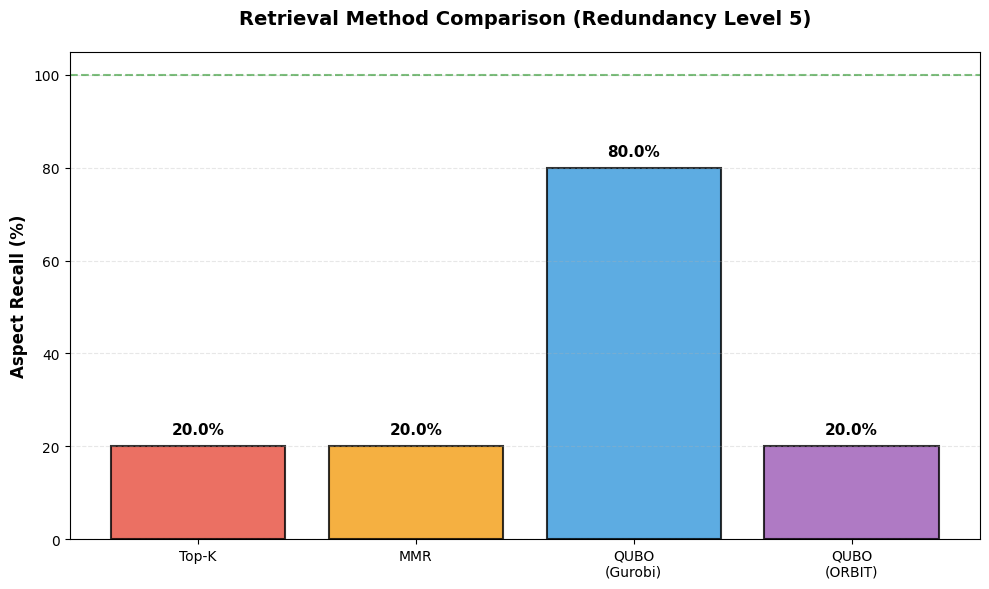


Visualization complete!


In [20]:
# Bar chart comparison
fig, ax = plt.subplots(figsize=(10, 6))

method_names = ['Top-K', 'MMR', 'QUBO\n(Gurobi)']
recalls = [topk_recall, mmr_recall, gurobi_recall]
colors = ['#e74c3c', '#f39c12', '#3498db']

if orbit_recall is not None:
    method_names.append('QUBO\n(ORBIT)')
    recalls.append(orbit_recall)
    colors.append('#9b59b6')

bars = ax.bar(method_names, recalls, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, recall in zip(bars, recalls):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'{recall:.1f}%',
            ha='center', va='bottom', fontweight='bold', fontsize=11)

ax.set_ylabel('Aspect Recall (%)', fontsize=12, fontweight='bold')
ax.set_title(f'Retrieval Method Comparison (Redundancy Level {redundancy_level})',
             fontsize=14, fontweight='bold', pad=20)
ax.set_ylim(0, 105)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.axhline(y=100, color='green', linestyle='--', alpha=0.5, linewidth=1.5, label='Perfect (100%)')

plt.tight_layout()
plt.show()

print(f"\nVisualization complete!")

---

## Key Takeaways

1. **Top-K** struggles with redundancy - selects duplicate chunks of the same aspect
2. **MMR** improves diversity by penalizing similarity to already-selected chunks
3. **QUBO (Gurobi)** uses classical optimization to find optimal relevance-diversity tradeoff
4. **QUBO (ORBIT)** uses quantum-inspired p-bit computing for the same optimization

Both QUBO methods balance:
- **Relevance**: Maximize similarity to query
- **Diversity**: Minimize similarity among selected chunks
- **Cardinality**: Ensure exactly k chunks are selected

The QUBO energy function:
$$E(x) = -\mathbf{r}^T\mathbf{x} + \alpha \mathbf{x}^T \mathbf{Q} \mathbf{x} + P(\sum x_i - k)^2$$

Where:
- $\mathbf{r}$ = relevance scores
- $\mathbf{Q}$ = pairwise similarity matrix (thresholded)
- $\alpha$ = diversity weight (0.04)
- $P$ = cardinality penalty (10.0)
- $k$ = target number of selections (5)